# We analyse one trajectory for a smooth landscape with MULTIPLE hidden units, high learning rate and then analyse the trajectories

In [1]:
import sys
import os
sys.path.append('Jerome_scripts_Original/PGM/')
sys.path.append('selfPackages/')
sys.path.append('Jerome_scripts_Original/')
sys.path.append('ffmpeg-3.4.2-32bit-static/')

import numpy as np
import scipy as sc
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import rbm
    import bm
except:
    print 'Compiling cy_utilities first'
    curr_dir = os.getcwd()
    os.chdir('PGM/')
    !python setup.py build_ext --inplace
    print 'Compilation done'
    os.chdir(curr_dir)
    
import pickle
from ising import IsingModel
import estimate_correlations_ising
from sklearn.utils import shuffle
import inlineMovies

In [90]:
#import dill
#dill.dump_session('./data_bruckner/data/notebookData/19_multipleUnits_dynamics')

In [2]:
import dill
dill.load_session('./data_bruckner/data/notebookData/19_multipleUnits_dynamics')

In [2]:
%%capture capt1
#Supress the output of the cell and save it to capt1

N = 100
beta = 1.
Num_configs = 1000000

#Generate spins using Gibbs Sampling MCMC
BM = bm.BM(N=N,nature='Spin')

#Define Couplings
BM.layer.couplings =  beta* (np.eye(N=N,k=1) + np.eye(N=N,k=-1))
BM.layer.couplings[0,-1] += beta
BM.layer.couplings[-1,0] += beta

data = BM.gen_data(Nchains=1,Nthermalize=0,Lchains=Num_configs,Nstep=400) # N steps.

#Train the model
RBM = rbm.RBM(visible = 'Spin', n_v=N, n_h = 100, hidden = 'Spin',zero_field = True)
results = RBM.fit(data,n_iter=250,verbose=0,learning_rate = 0.1,record=['W'],record_interval=1000,batch_size=100,N_MC= 20, lr_decay=False,batch_norm=False);


KeyboardInterrupt: 

In [6]:
# Finding Peak Centres:
peakCentre = np.zeros([np.shape(np.array(results['W']))[0],np.shape(np.array(results['W']))[1]])
peakCentre = np.argmax(abs(np.array(results['W'])),axis=2)

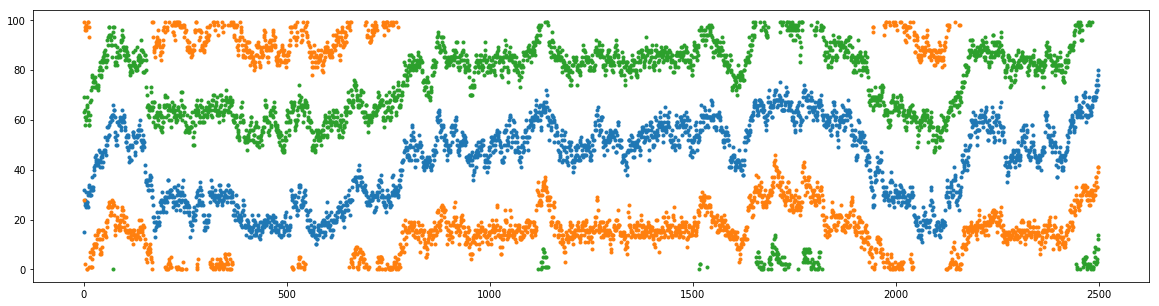

In [31]:
plt.figure(figsize=(20,5))
plt.plot(peakCentre,'.')

### Manual correction due to Periodic Boundary Conditions - If the position moves through the boundary, add or subtract the boundary value to it

In [33]:
peakCentrePBC = np.copy(peakCentre)
peakCentrePBC[(peakCentrePBC[:,1]>60),1] = peakCentrePBC[(peakCentrePBC[:,1]>60),1]-100
peakCentrePBC[(peakCentrePBC[:,2]<20),2] = peakCentrePBC[(peakCentrePBC[:,2]<20),2]+100

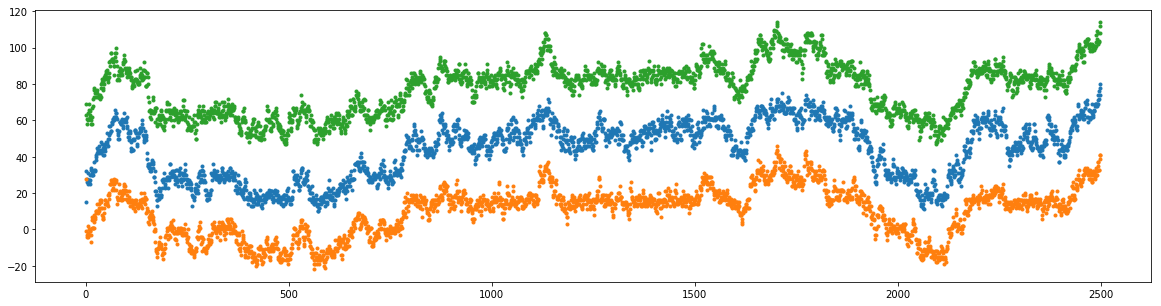

In [34]:
plt.figure(figsize=(20,5))
plt.plot(peakCentrePBC,'.')

(array([ -40.,  -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.]),
 <a list of 10 Text yticklabel objects>)

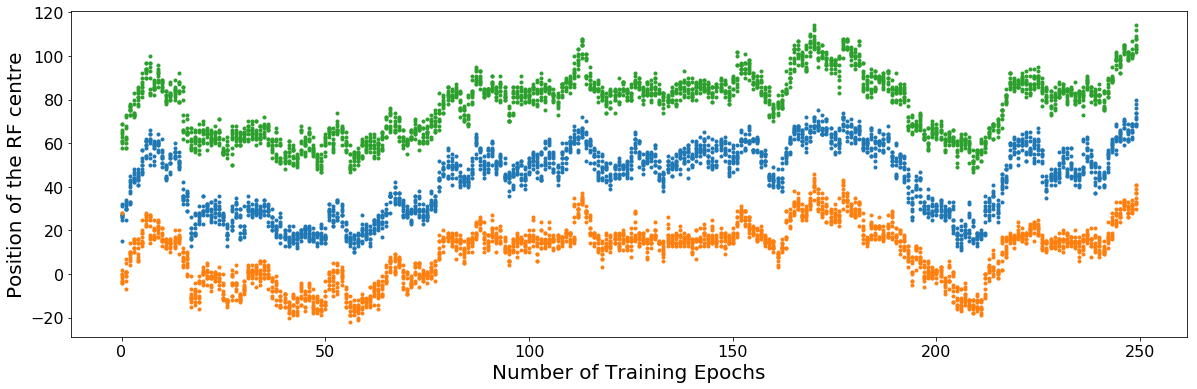

In [10]:
plt.figure(figsize=(20,6))
plt.plot(np.arange(len(peakCentrePBC))/10,peakCentrePBC,'.')
plt.xlabel('Number of Training Epochs',fontsize=20)
plt.ylabel('Position of the RF centre',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [41]:
peakCorr = np.zeros((2*len(peakCentrePBC)-1,6))
peakCorr[:,0] = np.correlate(peakCentrePBC[:,0],peakCentrePBC[:,0],'full')
peakCorr[:,1] = np.correlate(peakCentrePBC[:,1],peakCentrePBC[:,1],'full')
peakCorr[:,2] = np.correlate(peakCentrePBC[:,2],peakCentrePBC[:,2],'full')
peakCorr[:,3] = np.correlate(peakCentrePBC[:,0],peakCentrePBC[:,1],'full')
peakCorr[:,4] = np.correlate(peakCentrePBC[:,0],peakCentrePBC[:,2],'full')
peakCorr[:,5] = np.correlate(peakCentrePBC[:,1],peakCentrePBC[:,2],'full')

Text(0.5,1,u'CrossCorr 2&3')

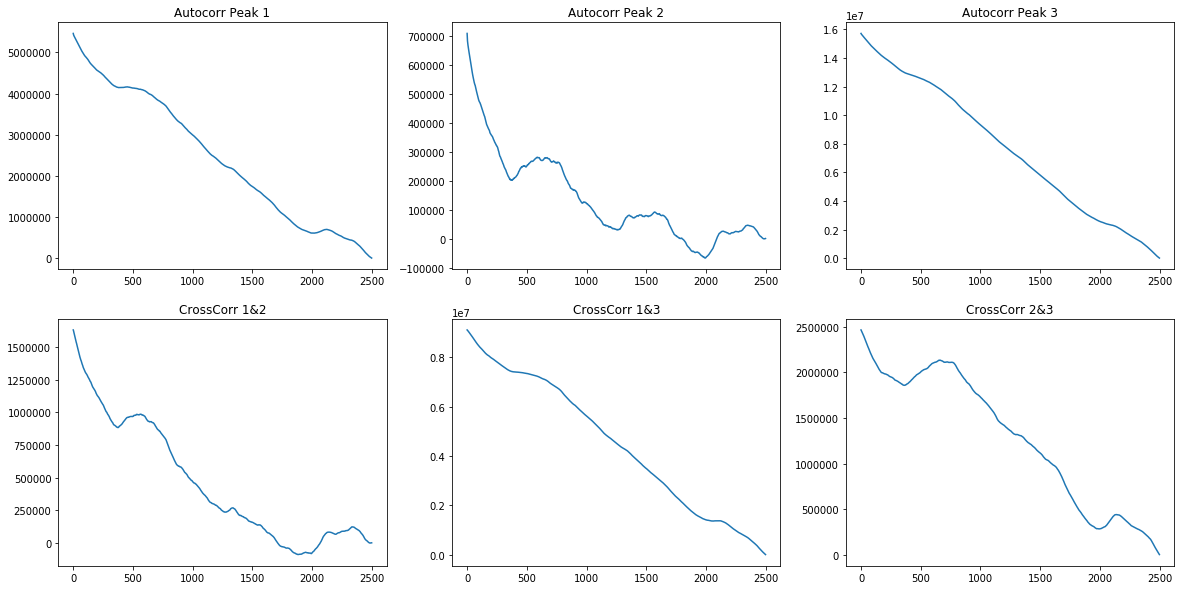

In [97]:
plt.figure(figsize=(20,10))

plt.subplot(231)
plt.plot(peakCorr[len(peakCorr)/2:-1,0])
plt.gca().set_title('Autocorr Peak 1')

plt.subplot(232)
plt.plot(peakCorr[len(peakCorr)/2:-1,1])
plt.gca().set_title('Autocorr Peak 2')

plt.subplot(233)
plt.plot(peakCorr[len(peakCorr)/2:-1,2])
plt.gca().set_title('Autocorr Peak 3')

plt.subplot(234)
plt.plot(peakCorr[len(peakCorr)/2:-1,3])
plt.gca().set_title('CrossCorr 1&2')

plt.subplot(235)
plt.plot(peakCorr[len(peakCorr)/2:-1,4])
plt.gca().set_title('CrossCorr 1&3')

plt.subplot(236)
plt.plot(peakCorr[len(peakCorr)/2:-1,5])
plt.gca().set_title('CrossCorr 2&3')

### Diffusion (MSD) analysis for this peak:

In [35]:
MSD = np.zeros([len(peakCentrePBC)/2,4])
peakCM = (peakCentrePBC[:,0] + peakCentrePBC[:,1] + peakCentrePBC[:,2])/3
for i in np.arange(len(peakCentrePBC)/2):
    MSD[i,0] = (np.sum((peakCentrePBC[:,0] - np.roll(peakCentrePBC[:,0],i))**2))/(len(peakCentrePBC[:,0]))
    MSD[i,1] = (np.sum((peakCentrePBC[:,1] - np.roll(peakCentrePBC[:,1],i))**2))/(len(peakCentrePBC[:,1]))
    MSD[i,2] = (np.sum((peakCentrePBC[:,2] - np.roll(peakCentrePBC[:,2],i))**2))/(len(peakCentrePBC[:,2]))
    MSD[i,3] = (np.sum((peakCM - np.roll(peakCM,i))**2))/(len(peakCM))
#linear_coeff = np.polyfit(np.arange(2500/2),MSD,1)

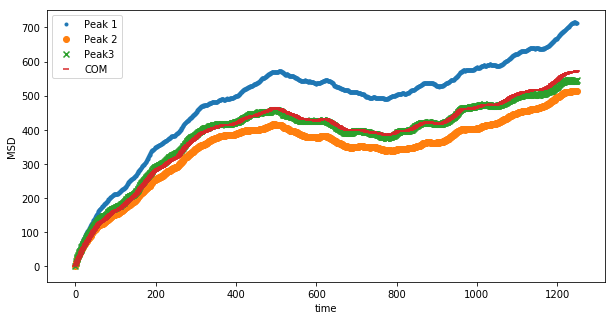

In [95]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(MSD)),MSD[:,0], marker='.',label = 'Peak 1')
plt.scatter(np.arange(len(MSD)),MSD[:,1], marker='o',label = 'Peak 2')
plt.scatter(np.arange(len(MSD)),MSD[:,2], marker='x',label = 'Peak3')
plt.scatter(np.arange(len(MSD)),MSD[:,3], marker='_',label = 'COM')
#plt.ylabel('Centre of Mass of the peaks')
plt.ylabel('MSD')
plt.xlabel('time')
plt.legend()